# Field Specialization Analysis

This notebook analyzes the specialization of research fields over time using two metrics:

1. Network modularity - measures how well-defined the boundaries between research clusters are
2. Minimum clusters for 50% coverage - tracks how many top clusters are needed to cover half of all papers

The analysis shows changes in the field structure from 1982 to 2025.


In [2]:
import json
import os
from collections import defaultdict
from typing import Dict, List, Tuple, Optional, Union
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

In [3]:
def load_data(data_dir: str, output_dir: str) -> pd.DataFrame:
    """
    Load the dataset and reference files.

    This method loads the main DataFrame, cluster labels, and legend files
    required for the analysis. It ensures that all necessary data is available
    for subsequent operations.

    Returns:
        self: The ClusterAnalyzer instance with loaded data.
    """
    # Load DataFrame
    pdf = os.path.join(data_dir, "08-analysis-data/df_analysis.pkl")
    df = pd.read_pickle(pdf)
    print(f"DataFrame loaded with rows: {len(df)}")

    # Load graph
    pg = os.path.join(data_dir, "08-analysis-data/graph_analysis.graphml")
    g = ig.read(pg)
    print(f"Graph loaded with {g.vcount()} vertices and {g.ecount()} edges.")
    # Load cluster labels
    labels_path = os.path.join(
        output_dir,
        "cluster-qualifications_2025/cluster-label-tree/cluster_labels_filtered.json",
    )
    with open(labels_path, "r") as f:
        cluster_label_dict = json.load(f)
    print(f"Cluster labels loaded with {len(cluster_label_dict)} entries.")

    # Load legend
    legend_path = os.path.join(
        output_dir,
        "cluster-qualifications_2025/cluster-label-tree/legend_labels_2025.json",
    )
    with open(legend_path, "r") as f:
        legend = json.load(f)
    print(f"Legend loaded with {len(legend)} entries.")
    return df, g, cluster_label_dict, legend


df, g, cluster_label_dict, legend = load_data(
    data_dir=os.getenv("DATA_DIR", "data"),
    output_dir=os.getenv("OUTPUT_DIR", "output"),
)

DataFrame loaded with rows: 36510
Graph loaded with 36510 vertices and 551227 edges.
Cluster labels loaded with 99 entries.
Legend loaded with 4 entries.


/opt/homebrew/Caskroom/miniconda/base/envs/bibliometrics/lib/python3.11/site-packages/igraph/io/files.py:295: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:488
  return reader(f, *args, **kwds)


# Nr of clusters that make up 50% of the total proportion of papers per year


In [9]:
# --- 1. Build df_counts ---
def create_counts_per_year_and_cluster(
    df: pd.DataFrame,
    year_column: str = "year",
    cluster_col: str = "cluster_alpha0.3_k10_res0.002",
) -> pd.DataFrame:
    """
    Create a DataFrame that counts the number of unique EIDs per year and cluster.

    Args:
        df (pd.DataFrame): The input DataFrame containing EIDs, years, and cluster labels.
        year_column (str): The name of the column containing the year information.
        cluster_col (str): The name of the column containing the cluster labels.

    Returns:
        pd.DataFrame: A DataFrame with columns for year, cluster, and paper count.
    """
    df_counts = df.groupby([year_column, cluster_col])["eid"].nunique().reset_index()
    df_counts.columns = [year_column, cluster_col, "paper_count"]

    # Sort by year and then by paper count (descending)
    df_counts = df_counts.sort_values(
        by=[year_column, "paper_count"], ascending=[True, False]
    )
    return df_counts


def analyze_cluster_proportions(
    df_counts,
    year_column="year",
    cluster_column="cluster_alpha0.3_k10_res0.002",
    threshold=0.5,
    year_start=1982,
    year_end=2025,
    year_step_size=5,
):
    """
    Creates a dict that maps each time window to the number of clusters needed
    to reach a certain threshold of cumulative paper counts (50%).

    Returns a dict: {(window_start, window_end): num_clusters_needed_for_threshold}
    """
    results = {}

    current_year = year_start
    while current_year <= year_end:
        window_start = current_year
        window_end = min(current_year + year_step_size - 1, year_end)

        # Filter data for this time window
        window_df = df_counts[
            (df_counts[year_column] >= window_start)
            & (df_counts[year_column] <= window_end)
        ]

        if len(window_df) == 0:
            current_year += year_step_size
            continue

        # Group by cluster and sum paper counts for this window
        cluster_counts = (
            window_df.groupby(cluster_column)["paper_count"].sum().reset_index()
        )
        total_papers = cluster_counts["paper_count"].sum()

        if total_papers == 0:
            current_year += year_step_size
            continue

        # Sort clusters by paper count (descending)
        cluster_counts_sorted = cluster_counts.sort_values(
            "paper_count", ascending=False
        )
        cumulative = cluster_counts_sorted["paper_count"].cumsum()

        # Find number of clusters needed to reach threshold
        num_clusters = (cumulative <= total_papers * threshold).sum() + 1
        results[(window_start, window_end)] = num_clusters

        current_year += year_step_size

    return results


def top_n_cluster_cumulative(
    df_counts,
    year_column="year",
    count_column="paper_count",
    n_top=5,
    year_start=1982,
    year_end=2025,
    year_step_size=5,
):
    """
    Creates a dict that maps each time window to the percentage of total
    papers that are in the top n clusters.

    Returns a dict: {(window_start, window_end): percent_of_papers_in_top_n_clusters}
    """
    results = {}

    current_year = year_start
    while current_year <= year_end:
        window_start = current_year
        window_end = min(current_year + year_step_size - 1, year_end)

        # Filter data for this time window
        window_df = df_counts[
            (df_counts[year_column] >= window_start)
            & (df_counts[year_column] <= window_end)
        ]

        if len(window_df) == 0:
            current_year += year_step_size
            continue

        # Group by cluster and sum paper counts for this window
        cluster_counts = window_df.groupby("cluster")[count_column].sum().reset_index()
        total_papers = cluster_counts[count_column].sum()

        if total_papers == 0:
            current_year += year_step_size
            continue

        # Sort clusters by paper count (descending)
        cluster_counts_sorted = cluster_counts.sort_values(
            count_column, ascending=False
        )
        cumulative = cluster_counts_sorted[count_column].cumsum()

        # Calculate percentage for top n clusters
        if len(cumulative) >= n_top:
            top_n_cumulative = cumulative.iloc[n_top - 1]
        elif len(cumulative) > 0:
            top_n_cumulative = cumulative.iloc[-1]
        else:
            top_n_cumulative = 0

        percent = (top_n_cumulative / total_papers * 100) if total_papers > 0 else 0
        results[(window_start, window_end)] = percent

        current_year += year_step_size

    return results

# Network Modularity over Time


In [5]:
def calculate_modularity(snapshot_graph, cluster_attribute="cluster"):
    """
    Calculate modularity for a graph with cluster assignments.

    Parameters:
    -----------
    snapshot_graph : igraph.Graph
        The graph to analyze
    cluster_attribute : str
        The vertex attribute containing cluster assignments

    Returns:
    --------
    float : The modularity value
    """
    # Get all clusters
    clusters = set(snapshot_graph.vs[cluster_attribute])

    # Build cluster membership mapping
    cluster_nodes = defaultdict(list)
    for v in snapshot_graph.vs:
        cluster_nodes[v[cluster_attribute]].append(v.index)

    # Build edge matrix between clusters
    cluster_edge_matrix = defaultdict(lambda: defaultdict(int))

    # Count internal edges for each cluster
    internal_edges = defaultdict(int)

    for edge in snapshot_graph.es:
        source_cluster = snapshot_graph.vs[edge.source][cluster_attribute]
        target_cluster = snapshot_graph.vs[edge.target][cluster_attribute]

        if source_cluster == target_cluster:
            internal_edges[source_cluster] += 1
        else:
            cluster_edge_matrix[source_cluster][target_cluster] += 1
            cluster_edge_matrix[target_cluster][source_cluster] += 1

    # Calculate modularity
    total_edges = snapshot_graph.ecount()

    if total_edges == 0:
        return 0

    modularity = 0

    # Calculate degree for each cluster (sum of all edges touching nodes in cluster)
    cluster_degrees = defaultdict(int)
    for cluster in clusters:
        # Internal edges count twice for degree
        cluster_degrees[cluster] = internal_edges[cluster] * 2
        # Add external edges
        cluster_degrees[cluster] += sum(cluster_edge_matrix[cluster].values())

    # Calculate modularity using the standard formula
    for cluster in clusters:
        # Actual internal edges
        actual_internal = internal_edges[cluster]

        # Expected edges under null model
        expected_internal = (cluster_degrees[cluster] ** 2) / (4 * total_edges)

        modularity += actual_internal - expected_internal

    modularity = modularity / total_edges

    return modularity


def create_temporal_snapshots(
    graph,
    year_start=1982,
    year_end=2025,
    year_step_size=5,
    print_stats=False,
):
    """
    Create temporal snapshots of the graph based on time windows.

    Parameters:
    -----------
    graph : igraph.Graph
        The full graph with 'year' vertex attribute
    year_start : int
        Starting year (inclusive)
    year_end : int
        Ending year (inclusive)
    year_step_size : int
        Size of each time window in years

    Returns:
    --------
    dict : Dictionary with (start_year, end_year) tuples as keys
    """
    temporal_data = {}

    # Create time windows that span the full range
    current_year = year_start
    while current_year <= year_end:
        window_start = current_year
        window_end = min(current_year + year_step_size - 1, year_end)

        # Identify nodes published within this time window
        nodes_in_window = [
            n for n in graph.vs if window_start <= n["year"] <= window_end
        ]

        # Only create snapshot if there are nodes in this window
        if nodes_in_window:
            # Create snapshot graph
            snapshot_graph = graph.subgraph(nodes_in_window).copy()

            # Calculate modularity (assuming this function exists)
            modularity = calculate_modularity(snapshot_graph)

            # Store results
            temporal_data[(window_start, window_end)] = {
                "graph": snapshot_graph,
                "n_nodes": snapshot_graph.vcount(),
                "n_edges": snapshot_graph.ecount(),
                "n_clusters": (
                    len(set(snapshot_graph.vs["cluster"]))
                    if "cluster" in snapshot_graph.vs.attributes()
                    else 0
                ),
                "modularity": modularity,
            }
            if print_stats == True:
                # Print statistics for this snapshot
                print(f"Snapshot from {window_start} to {window_end}:")
                print(
                    f"  Nodes: {snapshot_graph.vcount()}, Edges: {snapshot_graph.ecount()}"
                )
                print(
                    f"  Clusters: {len(set(snapshot_graph.vs['cluster'])) if 'cluster' in snapshot_graph.vs.attributes() else 0}"
                )
                print(f"  Modularity: {modularity:.4f}")

        current_year += year_step_size

    return temporal_data


def extract_time_series(temporal_data):
    """
    Extract time series data for plotting.

    Parameters:
    -----------
    temporal_data : dict
        Dictionary returned by create_temporal_snapshots

    Returns:
    --------
    dict : Dictionary with metric names as keys and lists of values
    """
    time_series = {
        "periods": [],
        "modularity": [],
        "n_nodes": [],
        "n_edges": [],
        "n_clusters": [],
    }

    for (year_start, year_end), data in sorted(temporal_data.items()):
        time_series["periods"].append(f"{year_start}-{year_end}")
        time_series["modularity"].append(data["modularity"])
        time_series["n_nodes"].append(data["n_nodes"])
        time_series["n_edges"].append(data["n_edges"])
        time_series["n_clusters"].append(data["n_clusters"])

    return time_series

# Plot both in a single figure


In [37]:
def plot_combined_analysis(modularity_data, coverage_data, save_path=None):
    """
    Create a figure with two subplots showing modularity and cluster coverage.

    Parameters:
    -----------
    modularity_data : dict
        Dictionary of {year: modularity_value}
    coverage_data : dict
        Dictionary of {year: min_clusters_for_50_percent}
    save_path : str, optional
        Path to save the figure
    """
    # Set style
    sns.set_theme(
        style="whitegrid",
        font_scale=1.5,
        rc={
            "font.family": "serif",
            "font.serif": ["Times New Roman"],
            "axes.titlesize": 22,
            "axes.labelsize": 12,
            "xtick.labelsize": 10,
            "ytick.labelsize": 10,
        },
    )

    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # for both plots
    x_labels = modularity_data["periods"]
    x_ticks = np.arange(len(x_labels))

    # Plot 1: Modularity
    ax1.plot(
        x_ticks,
        modularity_data["modularity"],
        marker="o",
        markersize=8,
        linewidth=2,
        color="#c994c7",
        markerfacecolor="white",
        markeredgewidth=2,
    )
    ax1.set_xlabel("Publication Year", labelpad=12)
    ax1.set_ylabel("Network Modularity", labelpad=12)
    ax1.grid(True, alpha=0.5, linestyle="--")
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_labels, rotation=45)
    ax1.tick_params(axis="x", rotation=45)

    # Plot 2: Cluster Coverage

    ax2.plot(
        x_ticks,
        coverage_data.values(),
        marker="o",
        markersize=8,
        linewidth=2,
        color="#c994c7",
        markerfacecolor="white",
        markeredgewidth=2,
    )
    ax2.set_xlabel("Publication Year", labelpad=12)
    ax2.set_xticks(x_ticks)
    ax2.set_xticklabels(x_labels, rotation=45)
    # Set y-axis should only show integers
    ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax2.set_ylabel("Min. Clusters for 50% Coverage", labelpad=12)
    ax2.grid(True, alpha=0.5, linestyle="--")
    ax2.tick_params(axis="x", rotation=45)

    # Remove top and right spines
    sns.despine(ax=ax1)
    sns.despine(ax=ax2)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=400, bbox_inches="tight", transparent=True)
    plt.show()

In [38]:
load_dotenv()

# Access environment variables
data_dir = os.getenv("DATA_DIR")
output_dir = os.getenv("OUTPUT_DIR")

df, g, cluster_label_dict, legend = load_data(data_dir=data_dir, output_dir=output_dir)

year_column = "year"
cluster_col = "cluster_alpha0.3_k10_res0.002"
year_start = 1982
year_end = 2025
year_step_size = 3


# apply all functions
df_counts = create_counts_per_year_and_cluster(
    df,
    year_column=year_column,
    cluster_col=cluster_col,
)

min_clusters_to_50 = analyze_cluster_proportions(
    df_counts,
    year_column=year_column,
    threshold=0.5,
    year_start=year_start,
    year_end=year_end,
    year_step_size=year_step_size,
)
temporal_data_modularity = create_temporal_snapshots(
    g, year_start=year_start, year_end=year_end, year_step_size=year_step_size
)
time_series_modularity = extract_time_series(temporal_data_modularity)

DataFrame loaded with rows: 36510


/opt/homebrew/Caskroom/miniconda/base/envs/bibliometrics/lib/python3.11/site-packages/igraph/io/files.py:295: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:488
  return reader(f, *args, **kwds)


Graph loaded with 36510 vertices and 551227 edges.
Cluster labels loaded with 99 entries.
Legend loaded with 4 entries.


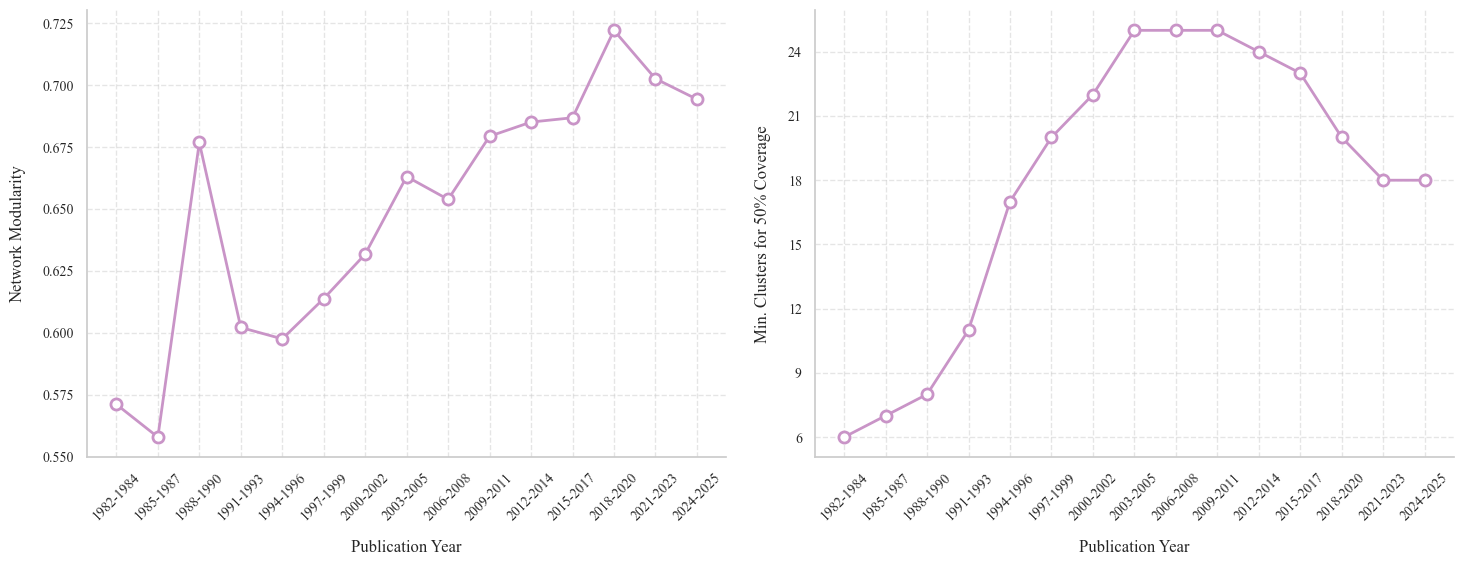

In [42]:
plot_combined_analysis(
    modularity_data=time_series_modularity,
    coverage_data=min_clusters_to_50,
    save_path=os.path.join(
        output_dir, "paper-output/modularity_and_coverage_analysis.png"
    ),
)